### Testing various models on PGP dataset

#### Imports and preprocessings

In [1]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score, accuracy_score

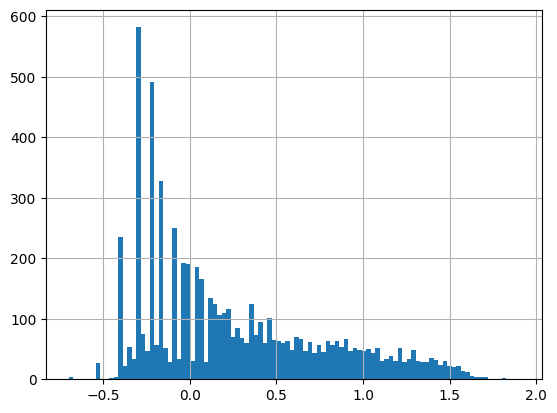

In [17]:
# it seems that the distribution of the two datasets are different:
# using cross-validation inside the train dataset will result in ~0.32 R^2, and the number if ~-0.1 for test dataset.
# Therefore, I will try only using train dataset for now.

train = pd.read_csv("data\\PGP_training_disguised.csv")
test = pd.read_csv("data\\PGP_test_disguised.csv")

train['Act'].hist(bins=100)

# need to reindex the test dataset for fitting and predicting
test = test.reindex(columns=train.columns, fill_value=0)
test.describe()

n = len(train)
perm = np.random.permutation(n)
test = train.iloc[perm[:int(0.1 * n)]]
calib = train.iloc[perm[int(0.1 * n):int(0.3 * n)]]
train = train.iloc[perm[int(0.3 * n):]]

In [3]:
len(train), len(calib), len(test)

(4480, 1280, 639)

In [4]:
train.head(5)

,MOLECULE,Act,D_8,D_36,D_37,D_38,D_39,D_40,D_41,D_42,...,D_10879,D_10880,D_10881,D_10883,D_10884,D_10974,D_10975,D_10976,D_10993,D_10994
2358,M_85863,-0.2218,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3102,M_93250,1.2225,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4558,M_110258,-0.3010,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3550,M_97758,0.4471,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5305,M_120611,0.1984,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
train.describe()
# not all descriptors are binary

,Act,D_8,D_36,D_37,D_38,D_39,D_40,D_41,D_42,D_43,...,D_10879,D_10880,D_10881,D_10883,D_10884,D_10974,D_10975,D_10976,D_10993,D_10994
count,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,...,4480.0,4480.0,4480.0,4480.0,4480.0,4480.0,4480.0,4480.0,4480.0,4480.0
mean,0.260409,0.000223,0.000223,0.002009,0.000223,0.000670,0.007589,0.002455,0.002232,0.002455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.528517,0.014940,0.014940,0.068443,0.014940,0.025872,0.133430,0.065084,0.051713,0.074670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-0.698800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.184025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.113900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.612700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.866000,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,3.000000,2.000000,3.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

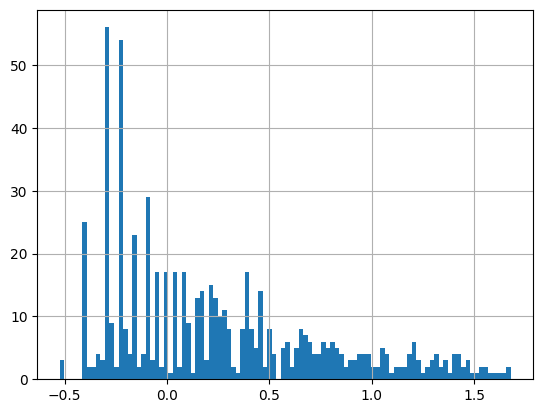

In [5]:
test['Act'].hist(bins=100)

#### Using conformal selection (classification) to select good molecules (< c)

In [6]:
Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

threshold = -0.3

Ytrain = 1 * (Ytrain < threshold)
Ycalib = 1 * (Ycalib < threshold)
Ytest = 1 * (Ytest < threshold)

##### Random forest predictor

In [25]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
rf.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=20, max_features='sqrt')

In [26]:
r2_score(Ycalib, rf.predict(Xcalib)), r2_score(Ytest, rf.predict(Xtest))

(0.3054079471777664, 0.3123270701835904)

In [27]:
accuracy_score(Ytest > 0.5, rf.predict(Xtest) > 0.5)

0.8748043818466353

##### Conformal selection procedure

In [28]:
calib_scores = Ycalib - rf.predict(Xcalib)          
calib_scores0 = -rf.predict(Xcalib)                     
calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold
 
test_scores = -rf.predict(Xtest)

In [33]:
from utility import BH, Bonferroni

q = 0.5

# selection target is 
true_reject = sum(Ytest > 0) 

# BH using residuals
BH_res, res_pvals = BH(calib_scores, test_scores, q, True )
# summarize
if len(BH_res) == 0:
    BH_res_fdp = 0
    BH_res_power = 0
else:
    BH_res_fdp = np.sum(Ytest[BH_res] <= 0) / len(BH_res)
    BH_res_power = np.sum(Ytest[BH_res] > 0) / true_reject if true_reject != 0 else 0
    
# only use relevant samples to calibrate
BH_rel = BH(calib_scores0[Ycalib <= 0], test_scores, q )
if len(BH_rel) == 0:
    BH_rel_fdp = 0
    BH_rel_power = 0
else:
    BH_rel_fdp = np.sum(Ytest[BH_rel] <= 0) / len(BH_rel)
    BH_rel_power = np.sum(Ytest[BH_rel] > 0) / true_reject if true_reject != 0 else 0
    
# use clipped scores
BH_2clip, clip_pvals = BH(calib_scores_2clip, test_scores, q, True )
if len(BH_2clip) == 0:
    BH_2clip_fdp = 0
    BH_2clip_power = 0
else:
    BH_2clip_fdp = np.sum(Ytest[BH_2clip] <= 0) / len(BH_2clip)
    BH_2clip_power = np.sum(Ytest[BH_2clip] > 0) / true_reject if true_reject != 0 else 0

# Bonferroni
Bonf = Bonferroni(calib_scores_2clip, test_scores, q )
if len(Bonf) == 0:
    Bonf_fdp = 0
    Bonf_power = 0
else:
    Bonf_fdp = np.sum(Ytest[Bonf] <= 0) / len(Bonf)
    Bonf_power = np.sum(Ytest[Bonf] > 0) / true_reject if true_reject != 0 else 0
    

In [35]:
BH_res_fdp, BH_res_power, BH_rel_fdp, BH_rel_power, BH_2clip_fdp, BH_2clip_power, Bonf_fdp, Bonf_power

(0.5,
 0.6632653061224489,
 0.2682926829268293,
 0.30612244897959184,
 0.5,
 0.6632653061224489,
 0.0,
 0.01020408163265306)

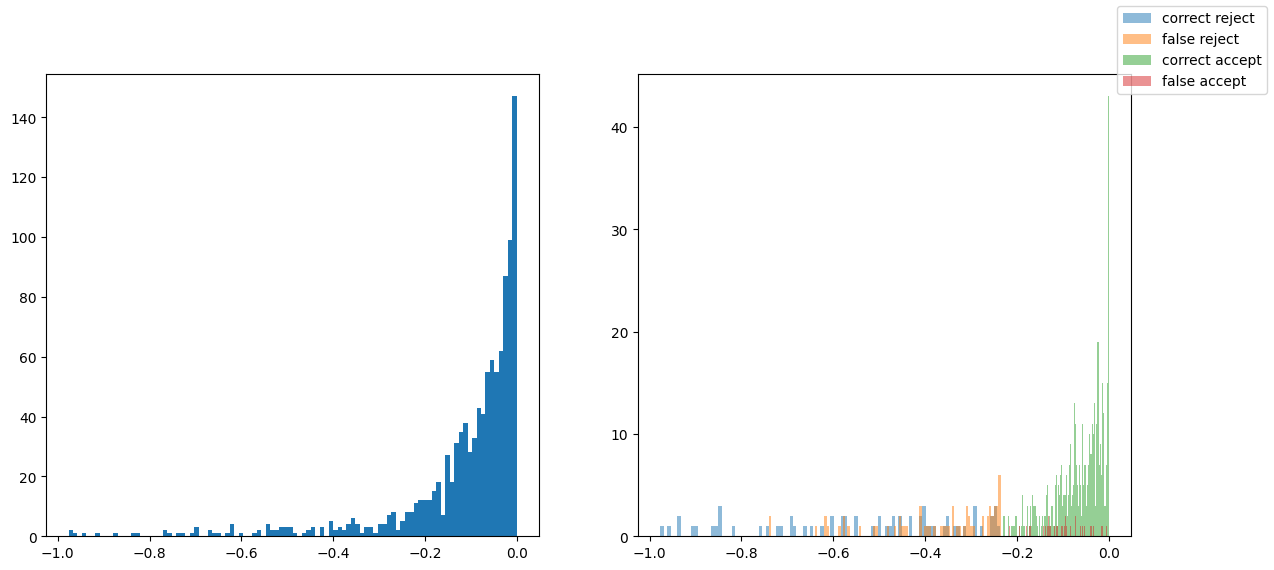

In [36]:
def intersect(l1, l2):
    return [value for value in l1 if value in l2]

BH_2clip_c = [i for i in range(len(Ytest)) if i not in BH_2clip]

reject = np.where(Ytest > 0)[0]
notreject = np.where(Ytest <= 0)[0]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].hist(calib_scores_2clip[calib_scores_2clip < 10], bins=100)

axs[1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')
fig.legend()
plt.show()

#### Using conformal selection (classification) to select unsure molecules (between c, d)

In [4]:
Ytrain, Ycalib, Ytest = train['Act'].to_numpy(), calib['Act'].to_numpy(), test['Act'].to_numpy()
Xtrain, Xcalib, Xtest = train.drop(columns=['MOLECULE', 'Act']).to_numpy(), calib.drop(columns=['MOLECULE', 'Act']).to_numpy(), test.drop(columns=['MOLECULE', 'Act']).to_numpy()

lower = -0.3
higher = 0.2

Ytrain = 1 * ((lower < Ytrain) & (Ytrain < higher))
Ycalib = 1 * ((lower < Ycalib) & (Ycalib < higher))
Ytest = 1 * ((lower < Ytest) & (Ytest < higher))

##### Random forest regressor

In [5]:
rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features='sqrt')
rf.fit(Xtrain, Ytrain)

RandomForestRegressor(max_depth=20, max_features='sqrt')

In [6]:
r2_score(Ycalib, rf.predict(Xcalib)), r2_score(Ytest, rf.predict(Xtest))

(0.21026088581891644, 0.19869147879523408)

In [7]:
accuracy_score(Ytest > 0.5, rf.predict(Xtest) > 0.5)

0.6541471048513302

##### Conformal selection procedure

In [24]:
calib_scores = Ycalib - rf.predict(Xcalib)          
calib_scores0 = -rf.predict(Xcalib)                     
calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib)   # Ycalib > 0.5 <=> original Ycalib < threshold
 
test_scores = -rf.predict(Xtest)

In [25]:
from utility import BH, Bonferroni

q = 0.2

# selection target is 
true_reject = sum(Ytest > 0) 

# BH using residuals
BH_res, res_pvals = BH(calib_scores, test_scores, q, True )
# summarize
if len(BH_res) == 0:
    BH_res_fdp = 0
    BH_res_power = 0
else:
    BH_res_fdp = np.sum(Ytest[BH_res] <= 0) / len(BH_res)
    BH_res_power = np.sum(Ytest[BH_res] > 0) / true_reject if true_reject != 0 else 0
    
# only use relevant samples to calibrate
BH_rel = BH(calib_scores0[Ycalib <= 0], test_scores, q )
if len(BH_rel) == 0:
    BH_rel_fdp = 0
    BH_rel_power = 0
else:
    BH_rel_fdp = np.sum(Ytest[BH_rel] <= 0) / len(BH_rel)
    BH_rel_power = np.sum(Ytest[BH_rel] > 0) / true_reject if true_reject != 0 else 0
    
# use clipped scores
BH_2clip, clip_pvals = BH(calib_scores_2clip, test_scores, q, True )
if len(BH_2clip) == 0:
    BH_2clip_fdp = 0
    BH_2clip_power = 0
else:
    BH_2clip_fdp = np.sum(Ytest[BH_2clip] <= 0) / len(BH_2clip)
    BH_2clip_power = np.sum(Ytest[BH_2clip] > 0) / true_reject if true_reject != 0 else 0

# Bonferroni
Bonf = Bonferroni(calib_scores_2clip, test_scores, q )
if len(Bonf) == 0:
    Bonf_fdp = 0
    Bonf_power = 0
else:
    Bonf_fdp = np.sum(Ytest[Bonf] <= 0) / len(Bonf)
    Bonf_power = np.sum(Ytest[Bonf] > 0) / true_reject if true_reject != 0 else 0
    

In [14]:
clip_pvals

,id,score,pval,threshold
481,481,-0.973854,0.000145,0.000782
274,274,-0.951591,0.001015,0.001565
605,605,-0.967430,0.001389,0.002347
290,290,-0.935516,0.001565,0.003130
464,464,-0.915757,0.001733,0.003912
...,...,...,...,...
456,456,-0.000000,0.604390,0.496870
241,241,-0.000000,0.604597,0.497653
20,20,-0.000000,0.605745,0.498435
172,172,-0.000000,0.605999,0.499218


In [26]:
BH_2clip_fdp, BH_2clip_power

(0.32413793103448274, 0.3828125)

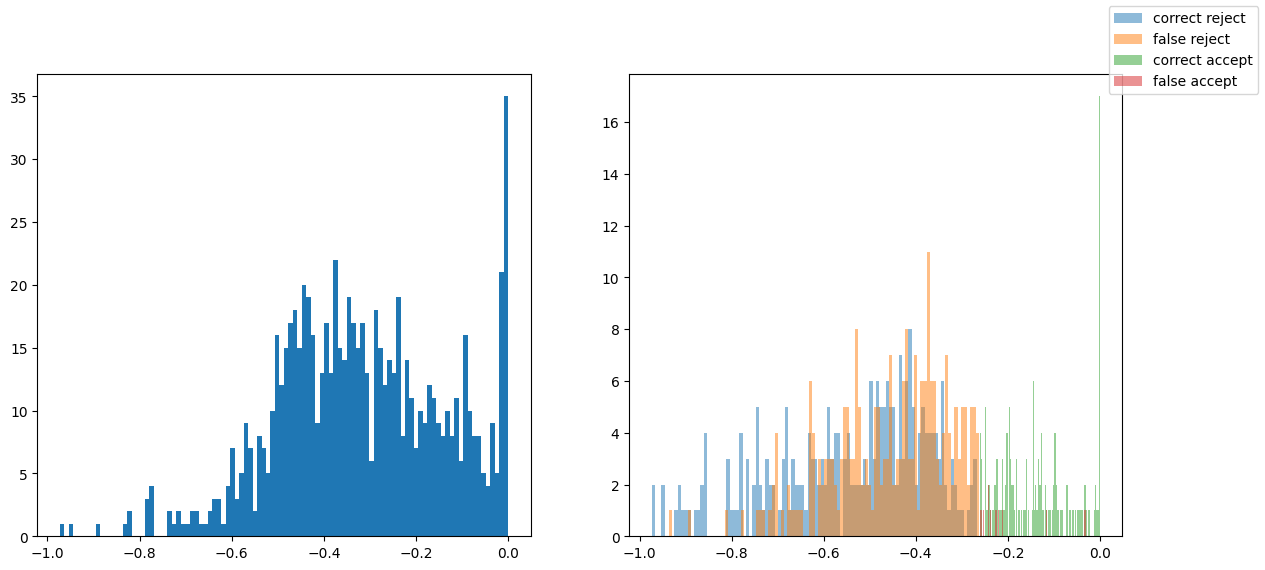

In [16]:
def intersect(l1, l2):
    return [value for value in l1 if value in l2]

BH_2clip_c = [i for i in range(len(Ytest)) if i not in BH_2clip]

reject = np.where(Ytest > 0)[0]
notreject = np.where(Ytest <= 0)[0]

correct_reject = intersect(BH_2clip, reject)
false_reject = intersect(BH_2clip, notreject)
correct_accept = intersect(BH_2clip_c, notreject)
false_accept = intersect(BH_2clip_c, reject)

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].hist(calib_scores_2clip[calib_scores_2clip < 10], bins=100)

axs[1].hist(test_scores[correct_reject], bins=100, alpha=0.5, label='correct reject')
axs[1].hist(test_scores[false_reject], bins=100, alpha=0.5, label='false reject')
axs[1].hist(test_scores[correct_accept], bins=100, alpha=0.5, label='correct accept')
axs[1].hist(test_scores[false_accept], bins=100, alpha=0.5, label='false accept')
fig.legend()
plt.show()

In [37]:
PGP_res = pd.read_csv("PGP_result.csv")
PGP_res = PGP_res.groupby(['q', 'regressor']).mean().reset_index().drop(columns=['Unnamed: 0'])
PGP_res

,q,regressor,r_squared,BH_res_fdp,BH_res_power,BH_res_nsel,BH_rel_fdp,BH_rel_power,BH_rel_nsel,BH_2clip_fdp,BH_2clip_power,BH_2clip_nsel,Bonf_fdp,Bonf_power,Bonf_nsel
0,0.1,rf,0.202285,0.070990,0.028127,8.57,0.076895,0.011328,3.28,0.094598,0.028443,8.66,0.055000,0.002152,0.66
1,0.2,rf,0.206916,0.194718,0.189835,62.77,0.111464,0.049921,15.64,0.200821,0.190220,62.94,0.081167,0.004199,1.28
2,0.5,rf,0.203308,0.502206,0.927298,479.63,0.295179,0.416826,154.21,0.502131,0.927215,479.50,0.117518,0.010029,3.08


In [38]:
PGP_res = pd.read_csv("PGP_result2.csv")
PGP_res = PGP_res.groupby(['q', 'regressor']).mean().reset_index().drop(columns=['Unnamed: 0'])
PGP_res

,q,regressor,r_squared,BH_res_fdp,BH_res_power,BH_res_nsel,BH_rel_fdp,BH_rel_power,BH_rel_nsel,BH_2clip_fdp,BH_2clip_power,BH_2clip_nsel,Bonf_fdp,Bonf_power,Bonf_nsel
0,0.1,rf,0.138640,0.000000,0.000010,0.01,0.0,0.000000,0.00,0.000000,0.000041,0.04,0.0,0.000062,0.06
1,0.2,rf,0.140718,0.000000,0.000227,0.22,0.0,0.000062,0.06,0.000000,0.000247,0.24,0.0,0.000051,0.05
2,0.5,rf,0.140609,0.514243,0.993605,1986.63,0.0,0.000196,0.19,0.514259,0.993605,1986.69,0.0,0.000154,0.15
